In [1]:
import json

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Layer, Input, LSTM, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from scipy.special import rel_entr


/Users/davidtruhlar/Documents/FIIT/BP/5GDigitalTwin/Implementation/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Global variables
BATCH_SIZE = 128
EPOCHS = 100

In [3]:
# Get the class weights from a JSON file
with open('./json/class_weights.json', "r") as f:
    class_weight_dict = json.load(f)

In [4]:
# Preprocessed data
X_train = np.load('preprocessed_data/X_train.npy')
y_train = np.load('preprocessed_data/y_train.npy')
X_test = np.load('preprocessed_data/X_test.npy')
y_test = np.load('preprocessed_data/y_test.npy')

In [5]:
# Transform the y_train and y_test labels to categorical
y_train_cat = to_categorical(y_train, num_classes=len(np.unique(y_train)))
y_test_cat = to_categorical(y_test, num_classes=len(np.unique(y_train)))

In [6]:
# Vlastná Attention vrstva (kompatibilná s LSTM výstupom)
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)  
        a = K.softmax(e, axis=1)              
        output = x * a                         
        return K.sum(output, axis=1)           

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [7]:
# Model definition
inputs = Input(shape=(60, X_train.shape[2]))
x = LSTM(64, return_sequences=True)(inputs)
x = Dropout(0.3)(x)
x = LSTM(32, return_sequences=True)(x)
x = Dropout(0.3)(x)
attention = AttentionLayer()(x)  # Tu sa aplikuje attention
dense1 = Dense(64, activation='relu')(attention)
drop1 = Dropout(0.3)(dense1)
outputs = Dense(len(np.unique(y_train)), activation='softmax')(drop1)

model = Model(inputs=inputs, outputs=outputs)

In [8]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [10]:
# Train the model
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    class_weight=class_weight_dict,
    callbacks=[early_stop]
)

Epoch 1/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.4550 - loss: 1.4096 - val_accuracy: 0.6477 - val_loss: 0.9126
Epoch 2/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.6434 - loss: 0.9193 - val_accuracy: 0.6795 - val_loss: 0.8000
Epoch 3/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.6779 - loss: 0.8173 - val_accuracy: 0.6935 - val_loss: 0.7435
Epoch 4/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.7080 - loss: 0.7383 - val_accuracy: 0.7481 - val_loss: 0.6436
Epoch 5/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.7355 - loss: 0.6639 - val_accuracy: 0.7533 - val_loss: 0.6218
Epoch 6/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.7417 - loss: 0.6453 - val_accuracy: 0.7717 - val_loss: 0.5634
Epoch 7/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.7639 - loss: 0.5925 - val_accuracy: 0.7539 - val_loss: 0.5718
Epoch 8/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.7670 - loss: 0.5647 -

274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


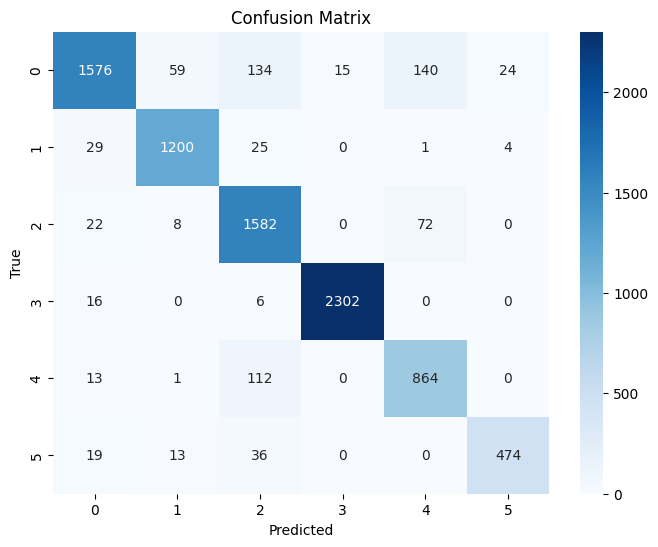

In [11]:
# Predictions
y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test

# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [12]:
# Classification report
print(classification_report(y_true, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.941     0.809     0.870      1948
           1      0.937     0.953     0.945      1259
           2      0.835     0.939     0.884      1684
           3      0.994     0.991     0.992      2324
           4      0.802     0.873     0.836       990
           5      0.944     0.875     0.908       542

    accuracy                          0.914      8747
   macro avg      0.909     0.907     0.906      8747
weighted avg      0.918     0.914     0.914      8747



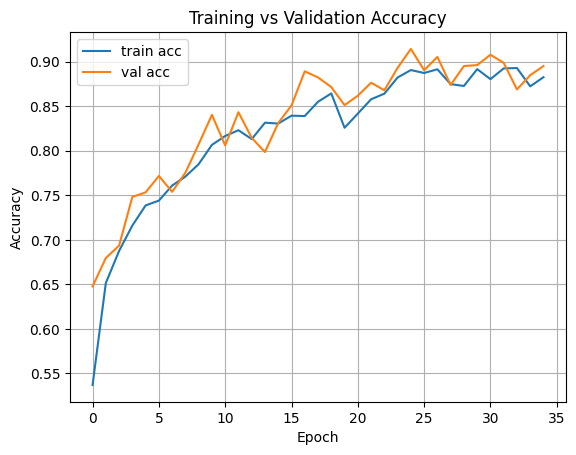

In [13]:
# Plot the training history
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Save the model
model.save('trained_models/lstm_attention_model.h5')
model.save('trained_models/lstm_attention_model.keras')